In [43]:
import sumolib
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
import sys

sys.path.append('..')

from utils.result_utils.plot_utils import plotNet
from utils.result_utils.dotdict import DotDict

In [2]:
#net_path = '../experiment/Simulations/Base/traci_exp.net.xml'
net_path = '../motorway/Simulations/Base/network.net.xml'
net = sumolib.net.readNet(net_path)

path = f'../motorway/Results/incident3/'

In [3]:
os.listdir(path)

['full_inci_data.npy',
 'network_info.npy',
 'ind_to_edge.json',
 'inci_data.npy',
 'simulations',
 'incident_settings.npy',
 'target_data.npy',
 'input_data.npy',
 'incident_info.npy',
 'counter_data.npy']

In [4]:
input_data = np.load(f'{path}/input_data.npy')
network_info = np.load(f'{path}/network_info.npy')

incident_info = np.load(f'{path}/incident_info.npy')

target_data = np.load(f'{path}/target_data.npy')

In [5]:
with open(f'{path}/ind_to_edge.json') as f:
    ind_to_link = json.load(f)

link_to_ind = {v: k for k, v in ind_to_link.items()}

In [6]:
link_objs = net.getEdges()
link_ids = np.array([link_obj.getID() for link_obj in link_objs])
link_mapping = {link: i for i, link in enumerate(link_ids)}

node_objs = net.getNodes()
node_ids = np.array([node_obj.getID() for node_obj in node_objs])
node_mapping = {node: i for i,node in enumerate(node_ids)}

for link in link_ids:
    assert int(link_to_ind[link]) == link_mapping[link]

# Natural formulation
This formulation follows how SUMO sees it internally - w. Junctions as nodes and edges as road links
One could argue that this is the most natural way to see a road network as a graph.

In [65]:
#AD_w_link_idxs = np.zeros((len(node_objs), len(node_objs)))

src = []
dst = []
for link in link_objs:
    src_node = node_mapping[link.getFromNode().getID()]
    src.append(src_node)
    
    dst_node = node_mapping[link.getToNode().getID()]
    dst.append(dst_node)

In [66]:
link_index = torch.tensor([src, dst]).squeeze()
node_attr = torch.ones(len(node_mapping))

In [67]:
print(f'x / node_attr {node_attr.shape=}')
print(f'link_index {link_index.shape=}')
print(f'link_attr {input_data.shape=} and {network_info.shape=} - moght have to merge to only 1 feature dim')
print(f'y / target {target_data.shape=}')

x / node_attr node_attr.shape=torch.Size([135])
link_index link_index.shape=torch.Size([2, 147])
link_attr input_data.shape=(1422, 147, 6, 10, 5) and network_info.shape=(1422, 147, 13) - moght have to merge to only 1 feature dim
y / target target_data.shape=(1422, 147, 4)


In [68]:
nat_form = Data(x = node_attr, edge_index=link_index, edge_attr=input_data[0], y=target_data[0])

In [69]:
print(nat_form)

Data(x=[135], edge_index=[2, 147], edge_attr=[147, 6, 10, 5], y=[147, 4])


In [99]:
node_coords = []
for node_obj  in node_objs:
    node_coords.append(node_obj.getCoord())
    
node_coords = np.array(node_coords)

In [102]:
lines = []
for link in link_index.T:
    src = link[0]
    dst = link[1]
    
    src_coord = node_coords[src]
    dst_coord = node_coords[dst]
    
    line = [src_coord, dst_coord]
    
    lines.append(line)
    

In [111]:
np.array(lines[0])[:,0]

array([3495.48, 3092.28])

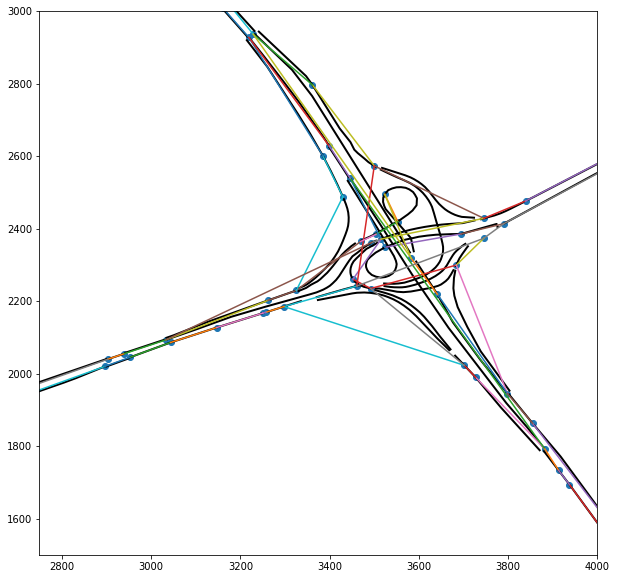

In [119]:
#net_path = '../experiment/Simulations/Base/traci_exp.net.xml'
plot_options = {'defaultColor': 'black',
                'defaultWidth': 2}
plot_options = DotDict(plot_options)

edge_colors = {}

fig, ax = plt.subplots(1, figsize=(10,10))

area = {'xmin':2750 , 'xmax':4000 ,'ymin':1500 ,'ymax':3000 }
ax = plotNet(net, edge_colors, {}, plot_options, net.getEdges()[0], ax, area=area)
ax.scatter(node_coords[:, 0 ], node_coords[:, 1])
for line in lines:
    np_line = np.array(line)
    ax.plot(np_line[:,0], np_line[:,1])

### This here should work w. junctions as node and detectors on the links. This however is limiting in the standard GCNs that can be used
Also need to collect all sims graph like in https://pytorch-geometric.readthedocs.io/en/latest/notes/create_dataset.html

BUT as long as I have the link index 

# Standard ML formulation
In this formulation the observational data is seen as node features.
I.e. in this case the observations is detectors on the road links.So we create are graph with the road links as nodes.

In [170]:
#AD_w_link_idxs = np.zeros((len(node_objs), len(node_objs)))

src = []
dst = []
for node in node_objs:
    incoming_links = node.getIncoming()
    outgoing_links = node.getOutgoing()
    incoming_idxs = [link_mapping[link.getID()] for link in incoming_links]
    outgoing_idxs = [link_mapping[link.getID()] for link in outgoing_links]
    
    
    for incoming_idx in incoming_idxs:
        for outgoing_idx in outgoing_idxs:
            src.append(incoming_idx)
            dst.append(outgoing_idx)
    
edge_index = torch.tensor([src, dst]).squeeze()

In [171]:
n_edges = edge_index.shape[1]


In [172]:
print(f'x / node_attr {input_data.shape=} and {network_info.shape=} - might have to merge to only 1 feature dim')
print(f'link_index {edge_index.shape=}')
print(f'link_attr {None}')
print(f'y / target {target_data.shape=}')

x / node_attr input_data.shape=(1422, 147, 6, 10, 5) and network_info.shape=(1422, 147, 13) - might have to merge to only 1 feature dim
link_index edge_index.shape=torch.Size([2, 159])
link_attr None
y / target target_data.shape=(1422, 147, 4)


In [173]:
edge_index

tensor([[  0,   6,   1,   1,   7,   2,   3,   4,   5,  72,   8,   8,  73, 137,
           9,  39,  99,  10,  12,  11, 116,  98,  13, 100,  14,  14,  15,  15,
          16,  25,  17,  67,  18,  21,  19,  20,  20, 109,  22,  48,  48,  23,
         110, 110,  24,  26, 135,  27,  44,  32,  32,  28, 119,  29,  30, 113,
          47,  31,  38,  38,  33, 127,  35,  34,  87,  87, 131, 131,  36,  37,
          37, 103, 103,  40, 112,  41,  71,  42,  43,  45,  78,  46,  50, 126,
         126, 125,  49,  51,  68, 138,  52,  77,  53,  80,  55,  54,  56,  60,
          58,  64,  59,  66,  61,  62,  63,  65,  76,  70, 136,  89,  89,  74,
          75,  75,  79,  79,  81,  82, 128,  83,  84,  85,  86, 122,  88,  95,
          96,  90,  91,  92,  93,  94,  97, 117, 102, 101, 104, 108, 105, 106,
         118, 129, 111, 120, 114, 115, 121, 123, 130, 134, 132, 133, 146, 139,
         140, 142, 143, 144, 145],
        [  7,   1,  20,  77,   2,   3,   4,   5,   6,   8,  45,  73,   9,   9,
          41,  41

In [188]:
link_adj = torch.zeros((147, 147))
for edge in edge_index.T:
    src = edge[0]
    dst = edge[1]
    link_adj[src, dst] = 1

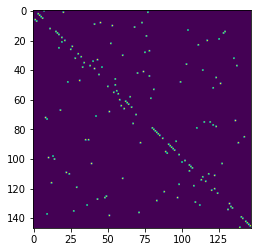

In [189]:
plt.imshow(link_adj)

In [190]:
AD_path = '../motorway/Results/incident3/link_AD_matrix.npy'
np.save(AD_path, adj)

In [191]:
edge_objs = net.getEdges()

def get_center(bounding_box):
    mean_x = np.mean([bounding_box[0], bounding_box[2]])
    mean_y = np.mean([bounding_box[1], bounding_box[3]])
    return mean_x, mean_y

edge_approx_centers = []
for edge_obj in edge_objs:
    approx_center = get_center(edge_obj.getBoundingBox())
    edge_approx_centers.append(approx_center)
    
edge_approx_centers = np.array(edge_approx_centers)

In [192]:
lines = []
for link in edge_index.T:
    src = link[0]
    dst = link[1]
    
    src_coord = edge_approx_centers[src]
    dst_coord = edge_approx_centers[dst]
    
    line = [src_coord, dst_coord]
    
    lines.append(line)
    

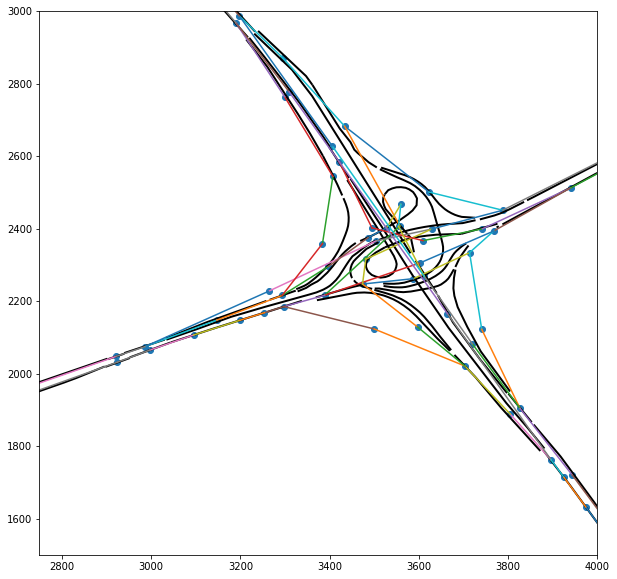

In [194]:
#net_path = '../experiment/Simulations/Base/traci_exp.net.xml'
plot_options = {'defaultColor': 'black',
                'defaultWidth': 2}
plot_options = DotDict(plot_options)

edge_colors = {}

fig, ax = plt.subplots(1, figsize=(10,10))

area = {'xmin':2750 , 'xmax':4000 ,'ymin':1500 ,'ymax':3000 }
ax = plotNet(net, edge_colors, {}, plot_options, net.getEdges()[0], ax, area=area)
ax.scatter(edge_approx_centers[:, 0 ], edge_approx_centers[:, 1])
#ax.scatter(node_coords[:, 0 ], node_coords[:, 1])
for line in lines:
    np_line = np.array(line)
    ax.plot(np_line[:,0], np_line[:,1])

# ADJ to rel_types for MPNN model

In [196]:
adj.shape

torch.Size([147, 147])

In [199]:
def encode_onehot(labels):
    """This function creates a onehot encoding.
    copied from https://github.com/ethanfetaya/NRI
    """
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)), dtype=np.int32)
    return labels_onehot

In [200]:
n_nodes = adj.shape[0]
off_diag = np.ones([n_nodes, n_nodes]) - np.eye(n_nodes)
rel_rec = torch.Tensor(encode_onehot(np.where(off_diag)[0]))
rel_send = torch.Tensor(encode_onehot(np.where(off_diag)[1])) # TODO double check how the order of the ADJ should be

In [201]:
rel_rec.shape

torch.Size([21462, 147])

In [212]:
rel_type = torch.zeros(rel_rec.shape[0])
for i, (rec, send) in enumerate(zip(rel_rec, rel_send)):
    rec_idx = torch.where(rec)[0]
    sender_idx = torch.where(send)[0]
    rel_type[i] = adj[sender_idx, rec_idx]

In [215]:
rel_type

tensor([0., 0., 0.,  ..., 0., 0., 1.])

In [206]:
torch.where(rec)[]

tensor([146])